
# <center>Estudio los datos medicamentos</center>
# <center>con distintos algoritmos de clasificacion</center>

**Índice**   
1. [KNN](#id1)
2. [Arbol de decisión](#id2)
3. [SVM](#id3)
4. [Regresión Logística](#id4)
5. [Random Forest](#id5)
6. [XGBoost](#id6)
7. [RESUMEN FINAL](#id7)



Carguemos las librerías necesarias

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBRegressor, XGBClassifier

from sklearn.model_selection import train_test_split,ParameterGrid
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import itertools

### Acerca del set de datos

Imagina que eres un investigador médico recolectando datos para un estudio. Has colectado datos de un grupo de pacientes, todos sufrieron la misma enfermedad. Durante su tratamiento, cada paciente respondio a una de 5 medicaciones, Droga A, Droga B, Droga c, Droga x e y. 

Parte de tu trabajo es construir un modelo para encontrar la droga apropiada para un próximo paciente con la misma enfermedad. El conjunto de características son Edad, Sexo, Presión Sanguínea y Colesterol. El objetivo es la droga ante la cual cada paciente respondió. 

Este es un ejemplo de un clasificador binario donde puedes utilizar un set de entrenamiento del set de datos 
para construir un árbol de decisión para predecir la clase de pacientes desconocidos o para prescribirle a un nuevo paciente.

### Cargar Datos a partir de un archivo CSV (Valores Delimitados por Coma)  

In [2]:
df = pd.read_csv("~/Desktop/MLandPython/dataset archive/drug200.csv", delimiter=",")
df[0:5]

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


# Visualización de Datos y Análisis 



#### Veamos cuántos de cada clase están en nuestro set de datos 

In [3]:
# Variables categoricas
df['Drug'].value_counts(), df['Sex'].value_counts(),df['BP'].value_counts(),df['Cholesterol'].value_counts()

(drugY    91
 drugX    54
 drugA    23
 drugB    16
 drugC    16
 Name: Drug, dtype: int64,
 M    104
 F     96
 Name: Sex, dtype: int64,
 HIGH      77
 LOW       64
 NORMAL    59
 Name: BP, dtype: int64,
 HIGH      103
 NORMAL     97
 Name: Cholesterol, dtype: int64)

Puedes explorar fácilmente tus datos utilizando técnicas de visualización:

/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Na_to_K'}>]], dtype=object)

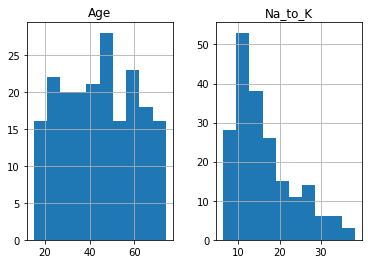

In [4]:
# Variables numericas
df.hist()

# Pre-procesamiento

Utilizando <b>my_data</b> como los datos de panda el archivo Drug.csv, declara las siguientes variables: <br>
<ul>
    <li> <b> X </b> as the <b> Feature Matrix </b> (datos de my_data) </li>
    <li> <b> y </b> como el <b> vector de respuesta </b> (target) </li>
  
</ul>

Elimina la columna que contiene el target ya que no posee valores numéricos.

Como te puedes imaginar, algunas características son de categoría, tales como __Sex__ o __BP__. Desafortunadamente, los árboles de Decisión Sklearn no manejan variables categóricas. Pero las podemos convertir en valores numéricos. __pandas.get_dummies()__
Convertir variable categórica en indicadores de variables.

In [5]:
df.shape

(200, 6)

In [6]:
vars_dep = df.drop('Drug',1).columns


X = df[['Age','Sex', 'BP', 'Cholesterol', 'Na_to_K']].values
X[0:5]

le_sex = preprocessing.LabelEncoder()
le_sex.fit(['F','M'])
X[:,1] = le_sex.transform(X[:,1]) 


le_BP = preprocessing.LabelEncoder()
le_BP.fit([ 'LOW', 'NORMAL', 'HIGH'])
X[:,2] = le_BP.transform(X[:,2])


le_Chol = preprocessing.LabelEncoder()
le_Chol.fit([ 'NORMAL', 'HIGH'])
X[:,3] = le_Chol.transform(X[:,3]) 

X[0:5]


array([[23, 0, 0, 0, 25.355],
       [47, 1, 1, 0, 13.093],
       [47, 1, 1, 0, 10.114],
       [28, 0, 2, 0, 7.798],
       [61, 0, 1, 0, 18.043]], dtype=object)

Ahora, podemos completar la variable objetivo (target).

In [7]:
y_label = df.columns[-1]
y = df[y_label]
y[0:5]

0    drugY
1    drugC
2    drugC
3    drugX
4    drugY
Name: Drug, dtype: object

## Normalizar los Datos 

La estandarización de Datos brinda a los datos cero media y varianza de unidad, es buena práctica, especialmente para algoritmos tales como KNN el cual se basa en distancia de casos:

In [8]:
# X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
# X[0:5]

## Train Test Split  
Al margen de la exactitud de la muestra, está el porcentaje de las predicciones correctas que el modelo hace de los datos para el que no ha sido entrenado. Al hacer un entrenamiento y prueba en el mismo set de datos, de seguro tendrán baja exactitud de muestra debido a la probabilidad de estar sobre dimensionado.

Es importante que nuestros modelos tengan una exactitud de muestra alta porque el propósito de cualquier modelos es lograr predicciones lo más certeras posibles sobre datos no conocidos. Entonces, ¿cómo podemos mejorar la precisión? Una forma es utilizar un enfoque de evaluación llamado Train/Test Split (Entrenar/Evaluar Dividir).
Esta forma requiere dividir el set de datos en conjuntos de entrenamiento y prueba, los cuales son mutuamente exclusivos. Luego de ello, se entrena con el conjunto de entrenamiento y se prueba con el conjunto de prueba.

Este método brinda una evaluación más precisa porque el set de prueba no es parte del conjunto de datos que ha sido utilizado para entrenar los datos. Es más realista para los problemas actuales.


In [9]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Set de Entrenamiento:', X_train.shape,  y_train.shape)
print ('Set de Prueba:', X_test.shape,  y_test.shape)


Set de Entrenamiento: (160, 5) (160,)
Set de Prueba: (40, 5) (40,)


# Clasificación 

<a name="id1"></a>
## K-vecinos más cercano (K-NN)

### Entrenamiento

Comencemos con el algoritmo con k=4 por ahora:

In [10]:
k = 6
#Entrenar el Modelo y Predecir  
model_knn = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
model_knn

KNeighborsClassifier(n_neighbors=6)

### Predicción
podemos utilizar el modelo para predecir el set de prueba:

In [11]:
yhat = model_knn.predict(X_test)
yhat[0:5]

array(['drugY', 'drugY', 'drugY', 'drugY', 'drugC'], dtype=object)

### Evaluación de certeza
En clasificación multietiqueta, la función __classification accuracy score__ computa la certeza del subconjunto. Esta función es igual a la función jaccard_similarity_score. Básicamente, calcula cómo se relacionan las etiquetas actuales con las etiquetas predichas dentro del set de pruebas.

In [12]:
from sklearn import metrics
# Esto de entrenar el set de certeza para que es?
print("Precision sobre datos entrenados: ", accuracy_score(y_train, model_knn.predict(X_train)))
print("Precision sobre datos nuevos de test: ", accuracy_score(y_test, yhat))

Precision sobre datos entrenados:  0.83125
Precision sobre datos nuevos de test:  0.65


#### ¿Qué paso con otro K?
K en KNN, es el número de los vecinos más cercanos para examinar. Se supone que el Usuario lo indique. Por lo tanto, ¿cómo elegimos el correcto K?
La solución general es reservar una parte de los datos para probaar la certeza del modelo. Luego, elegimos k =1, lo utilizamos como parte del entrenamiento para modelar, y calculamos la certeza de la predicción utilizando todas las muestras del set de pruebas. Repetir este proceso, aumentando el k, y viendo luego, cual es el mejor k para el modelo.

Podemos calcular la certeza de KNN para diferentes Ks.

In [13]:
Ks = 100
mean_acc = np.zeros((Ks-3))
std_acc = np.zeros((Ks-3))

for n in range(3,Ks-2):
    
    #Entrenar el Modelo y Predecir  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])


#### Dibujo de la certeza del modelo para diferentes números de vecinos

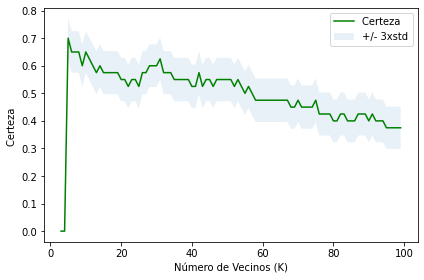

In [14]:
plt.plot(range(3,Ks),mean_acc,'g')
plt.fill_between(range(3,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Certeza ', '+/- 3xstd'))
plt.ylabel('Certeza ')
plt.xlabel('Número de Vecinos (K)')
plt.tight_layout()
plt.show()

In [15]:
print( "La mejor aproximación de certeza fue con ", mean_acc.max(), "con k=", mean_acc.argmax()+1)

La mejor aproximación de certeza fue con  0.7 con k= 3


In [16]:
#Me quedo con el modelo mejor y lo entreno con X e Y train
knn_model = KNeighborsClassifier(n_neighbors = mean_acc.argmax()+1)
knn_model.fit(X_train,y_train)

#Hago predicción con X test y lo comparo con y test
ypred = knn_model.predict(X_train)
yhat = knn_model.predict(X_test)
  
#print('Parametros del mejor arbol: ',resultados.at[0,'criterion'],resultados.at[0,'max_depth'],resultados.at[0,'max_features'])    
knn_acc_train = accuracy_score(y_train, ypred)
knn_acc_test = accuracy_score(y_test, yhat)

print("Precisión de entrenamiento: ", knn_acc_train)
print("Precisión de test: ", knn_acc_test)
knn_model


Precisión de entrenamiento:  0.84375
Precisión de test:  0.7


KNeighborsClassifier(n_neighbors=3)

In [17]:
print(confusion_matrix(y_test, yhat, labels=sorted(df['Drug'].unique())))
print (classification_report(y_test, yhat))

[[ 3  0  1  2  0]
 [ 0  2  0  1  0]
 [ 1  1  2  1  0]
 [ 0  2  1  6  2]
 [ 0  0  0  0 15]]
              precision    recall  f1-score   support

       drugA       0.75      0.50      0.60         6
       drugB       0.40      0.67      0.50         3
       drugC       0.50      0.40      0.44         5
       drugX       0.60      0.55      0.57        11
       drugY       0.88      1.00      0.94        15

    accuracy                           0.70        40
   macro avg       0.63      0.62      0.61        40
weighted avg       0.70      0.70      0.69        40



<a name="id2"></a>
## Arbol de decisión

### Modelado y entrenamiento

In [18]:
## Optimizo los hiperparámetros
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'max_features': [3, 4, 5],
                 'max_depth'   : [3, 4, 5, 10],
                 'criterion'   : [ 'entropy','gini']
                }
            )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'accuracy': []}

for params in param_grid:
    
    modelo = DecisionTreeClassifier(        
                random_state = 123,
                ** params
             )
    
    modelo.fit(X_train, y_train)
    yhat2= modelo.predict(X_test)
    
    resultados['params'].append(params)
    resultados['accuracy'].append(accuracy_score(y_test,yhat2))
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados.head(7)

Modelo: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 3} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 4} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 5} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 4, 'max_features': 3} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 4, 'max_features': 4} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 4, 'max_features': 5} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 3} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 4} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 5} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 3} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 4} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 5} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 3} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 4} ✓
Modelo: {'criterion': '

,accuracy,criterion,max_depth,max_features
19,0.975,gini,5,4
22,0.975,gini,10,4
10,0.975,entropy,10,4
7,0.975,entropy,5,4
23,0.950,gini,10,5
8,0.950,entropy,5,5
20,0.950,gini,5,5


In [19]:
#Creo el modelo y lo entreno con X e Y train
resultados = resultados.reset_index(drop=True)
dt_model = DecisionTreeClassifier(criterion=resultados.at[0,'criterion'],
                                  max_depth = resultados.at[0,'max_depth'],
                                  max_features = resultados.at[0,'max_features'])
dt_model.fit(X_train,y_train)

#Hago predicción con X test y lo comparo con y test
ypred = dt_model.predict(X_train)
yhat2 = dt_model.predict(X_test)
 
#print('Parametros del mejor arbol: ',resultados.at[0,'criterion'],resultados.at[0,'max_depth'],resultados.at[0,'max_features'])    
dt_acc_train = accuracy_score(y_train, ypred)
dt_acc_test = accuracy_score(y_test, yhat2)

print("Precisión de entrenamiento: ", dt_acc_train)
print("Precisión de test: ", dt_acc_test)
dt_model

Precisión de entrenamiento:  1.0
Precisión de test:  0.95


DecisionTreeClassifier(max_depth=5, max_features=4)

In [20]:
print(confusion_matrix(y_test, yhat2, labels=sorted(df['Drug'].unique())))
print (classification_report(y_test, yhat2))

[[ 6  0  0  0  0]
 [ 1  2  0  0  0]
 [ 0  0  5  0  0]
 [ 0  0  0 10  1]
 [ 0  0  0  0 15]]
              precision    recall  f1-score   support

       drugA       0.86      1.00      0.92         6
       drugB       1.00      0.67      0.80         3
       drugC       1.00      1.00      1.00         5
       drugX       1.00      0.91      0.95        11
       drugY       0.94      1.00      0.97        15

    accuracy                           0.95        40
   macro avg       0.96      0.92      0.93        40
weighted avg       0.96      0.95      0.95        40



In [21]:
importancia_predictores = pd.DataFrame(
                            {'predictor': vars_dep,
                             'importancia': dt_model.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
4,Na_to_K,0.501774
2,BP,0.326840
0,Age,0.126996
3,Cholesterol,0.044389
1,Sex,0.000000


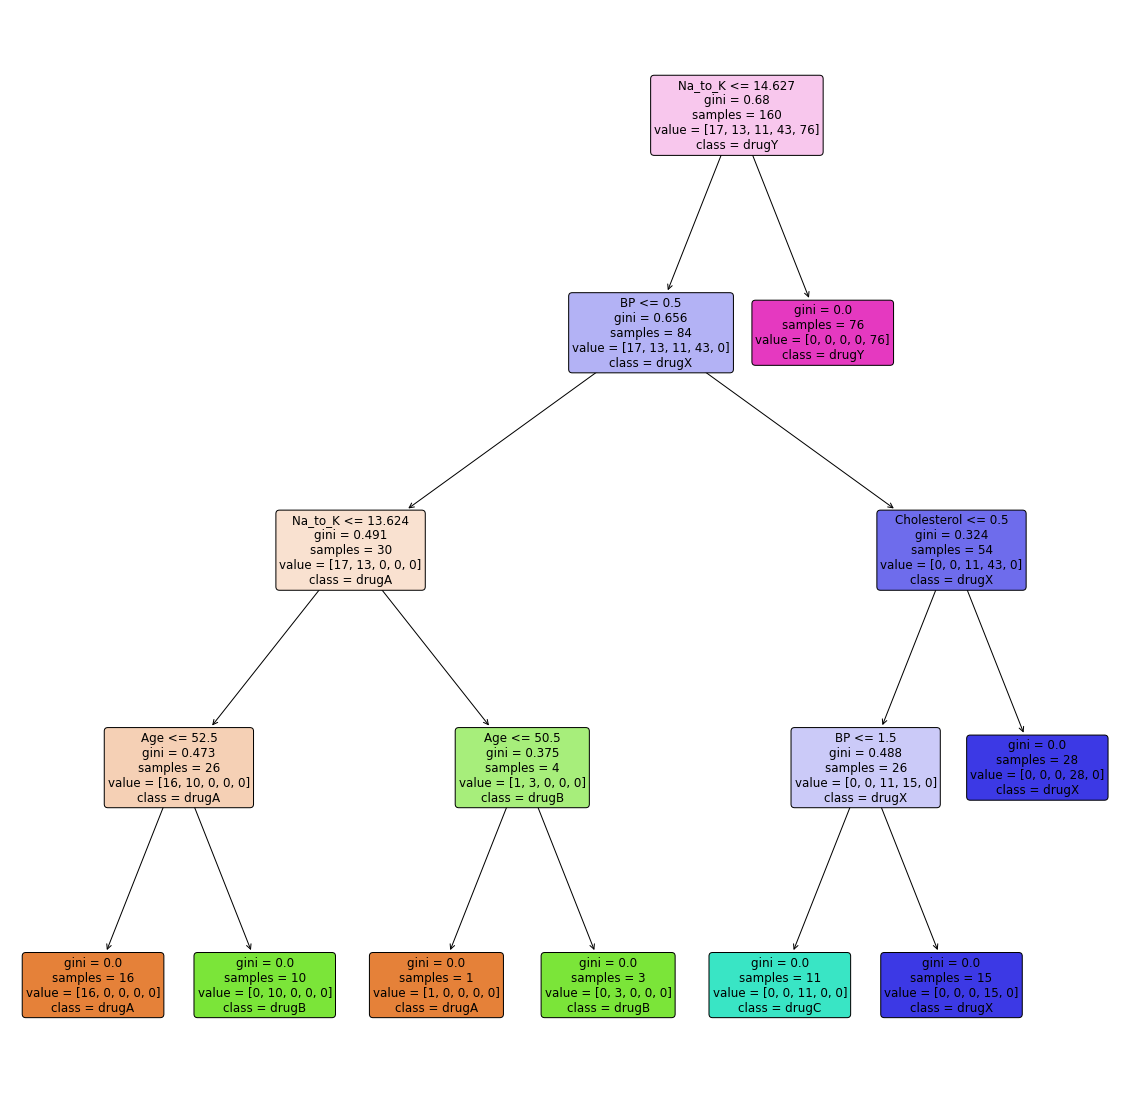

In [22]:
#Preparo las etiquetas del arbol
featureNames = vars_dep
targetNames = sorted(df["Drug"].unique().astype('str'))

#Esto Genera bien el fichero .dot
# arbol_dot = tree.export_graphviz(drugTree, out_file='drugtree.dot',
#                                  feature_names=featureNames, class_names=targetNames ,
#                                  filled=True, special_characters=True)  

#Esto pinta bien el arbol, hay que poner antes el tamaño de la figura, sino lo hace muy pequeño
plt.figure(figsize=(20, 20))
plot_tree(dt_model, feature_names=featureNames, class_names=targetNames, filled=True, rounded=True,)
plt.show()

<a name="id3"></a>
## SVM Support Vector Machines 

In [23]:
# Itero con los 4 posibles kernel de SVM para ver cual es el mejor
kernel_params=['linear','poly','rbf','sigmoid']
acc_svm = pd.DataFrame(index=kernel_params)

for i in kernel_params:
    svm_model = svm.SVC(kernel=i)
    svm_model.fit(X_train, y_train)
    y_hat3 = svm_model.predict(X_test)
    acc_svm.at[i,'accuracy'] = accuracy_score(y_test, y_hat3)

# Extraigo el mejor
mejor_kernel = acc_svm[acc_svm['accuracy']==acc_svm['accuracy'].max()].index
mejor_kernel = np.array(mejor_kernel).astype('str')
print('El mejor kernel es ', mejor_kernel[0],'con una precisión de: ',acc_svm['accuracy'].max())
acc_svm

El mejor kernel es  linear con una precisión de:  0.975


,accuracy
linear,0.975
poly,0.525
rbf,0.550
sigmoid,0.325


In [24]:
# Construyo el modelo final con ese Kernel
svm_model = svm.SVC(kernel=mejor_kernel[0])
svm_model.fit(X_train,y_train)


#Hago predicción con X train y test
ypred = svm_model.predict(X_train)
yhat3 = svm_model.predict(X_test)

svm_acc_train = accuracy_score(y_train, ypred)
svm_acc_test = accuracy_score(y_test, yhat3)

print("Precisión de entrenamiento: ", svm_acc_train)
print("Precisión de test: ", svm_acc_test)

svm_model

Precisión de entrenamiento:  1.0
Precisión de test:  0.975


SVC(kernel='linear')

In [25]:
print(confusion_matrix(y_test, yhat3, labels=sorted(df['Drug'].unique())))
print (classification_report(y_test, yhat3))

[[ 6  0  0  0  0]
 [ 1  2  0  0  0]
 [ 0  0  5  0  0]
 [ 0  0  0 11  0]
 [ 0  0  0  0 15]]
              precision    recall  f1-score   support

       drugA       0.86      1.00      0.92         6
       drugB       1.00      0.67      0.80         3
       drugC       1.00      1.00      1.00         5
       drugX       1.00      1.00      1.00        11
       drugY       1.00      1.00      1.00        15

    accuracy                           0.97        40
   macro avg       0.97      0.93      0.94        40
weighted avg       0.98      0.97      0.97        40



<a name="id4"></a>
## Regresion Logística

In [26]:
# Itero con los 5 posibles Solver de Reg Logística para ver cual es el mejor
solver_params=['lbfgs','liblinear','sag','saga','newton-cg']
acc_lr = pd.DataFrame(index=solver_params)

for i in solver_params:
    lr_model = LogisticRegression(C=0.01, solver=i)
    lr_model.fit(X_train, y_train)
    yhat4 = lr_model.predict(X_test)
    acc_lr.at[i,'accuracy'] = accuracy_score(y_test, yhat4)

# Extraigo el mejor
mejor_solver = acc_lr[acc_lr['accuracy']==acc_lr['accuracy'].max()].index
mejor_solver = np.array(mejor_solver).astype('str')
print('El mejor kernel es ', mejor_solver[0],'con una precisión de: ',acc_lr['accuracy'].max())
acc_lr  


El mejor kernel es  sag con una precisión de:  0.65


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was re

,accuracy
lbfgs,0.55
liblinear,0.60
sag,0.65
saga,0.65
newton-cg,0.55


In [27]:
# Construyo el modelo final con ese Solver
lr_model = LogisticRegression(C=0.01,solver=mejor_solver[0])
lr_model.fit(X_train, y_train)

#Hago predicción con X train y test
ypred = lr_model.predict(X_train)
yhat4 = lr_model.predict(X_test)

lr_acc_train = accuracy_score(y_train, ypred)
lr_acc_test = accuracy_score(y_test, yhat4)

print("Precisión de entrenamiento: ", lr_acc_train)
print("Precisión de test: ", lr_acc_test)

lr_model

Precisión de entrenamiento:  0.6625
Precisión de test:  0.65


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(C=0.01, solver='sag')

In [28]:
print(confusion_matrix(y_test, yhat4, labels=sorted(df['Drug'].unique())))
print (classification_report(y_test, yhat4))

[[ 0  0  0  1  5]
 [ 0  0  0  2  1]
 [ 0  0  0  3  2]
 [ 0  0  0 11  0]
 [ 0  0  0  0 15]]
              precision    recall  f1-score   support

       drugA       0.00      0.00      0.00         6
       drugB       0.00      0.00      0.00         3
       drugC       0.00      0.00      0.00         5
       drugX       0.65      1.00      0.79        11
       drugY       0.65      1.00      0.79        15

    accuracy                           0.65        40
   macro avg       0.26      0.40      0.32        40
weighted avg       0.42      0.65      0.51        40



/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

<a name="id5"></a>
## Random Forest

In [29]:

# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'max_features': [3, 4, 5],
                 'max_depth'   : [3, 10,20],
                 'criterion'   : ['gini', 'entropy']
                }
            )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_accuracy': []}

for params in param_grid:
    
    modelo = RandomForestClassifier(
                n_estimators= 100,        
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    modelo.fit(X_train, y_train)
    
    resultados['params'].append(params)
    resultados['oob_accuracy'].append(modelo.oob_score_)
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados = resultados.reset_index(drop=True)
resultados.head(4)

Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 3} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 4} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 5} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 3} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 4} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 5} ✓
Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 3} ✓
Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 4} ✓
Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 5} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 3} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 4} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 5} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 3} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 4} ✓
Modelo: {'criterion': 'entropy', 'max_d

,oob_accuracy,criterion,max_depth,max_features
0,1.0,entropy,20,5
1,1.0,entropy,10,3
2,1.0,entropy,20,4
3,1.0,gini,10,3


In [30]:
#Creo el modelo y lo entreno con X e Y train
rf_model = RandomForestClassifier(criterion=resultados.at[0,'criterion'],
                                  max_depth = resultados.at[0,'max_depth'],
                                  max_features = resultados.at[0,'max_features'])
#rf_model = DecisionTreeClassifier(criterion="gini", max_depth = 10, max_features = 5,n_estimators= 100,random_state = 123)
rf_model.fit(X_train,y_train)

#Hago predicción con Y test
ypred = rf_model.predict(X_train)
yhat5 = rf_model.predict(X_test)

rf_acc_train = accuracy_score(y_train, ypred)
rf_acc_test = accuracy_score(y_test, yhat5)

print("Precisión de entrenamiento: ", rf_acc_train)
print("Precisión de test: ", rf_acc_test)

rf_model

Precisión de entrenamiento:  1.0
Precisión de test:  0.95


RandomForestClassifier(criterion='entropy', max_depth=20, max_features=5)

In [31]:
importancia_predictores = pd.DataFrame(
                            {'predictor': vars_dep,
                             'importancia': rf_model.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
4,Na_to_K,0.525118
2,BP,0.314845
0,Age,0.096296
3,Cholesterol,0.063741
1,Sex,0.000000


In [32]:
print(confusion_matrix(y_test, yhat5, labels=sorted(df['Drug'].unique())))
print (classification_report(y_test, yhat5))

[[ 6  0  0  0  0]
 [ 1  2  0  0  0]
 [ 0  0  5  0  0]
 [ 0  0  0 10  1]
 [ 0  0  0  0 15]]
              precision    recall  f1-score   support

       drugA       0.86      1.00      0.92         6
       drugB       1.00      0.67      0.80         3
       drugC       1.00      1.00      1.00         5
       drugX       1.00      0.91      0.95        11
       drugY       0.94      1.00      0.97        15

    accuracy                           0.95        40
   macro avg       0.96      0.92      0.93        40
weighted avg       0.96      0.95      0.95        40



<a name="id6"></a>
## XGBoost

In [33]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [100, 500, 1000],
                 'learning_rate': [0.01, 0.05, 0.1],
                 'max_depth'   : [3, 5, 7],
                 'gamma' : [0.1, 0.2]
                }
            )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'accuracy': []}

for params in param_grid:
    
    xgb_model = XGBClassifier(
#               use_label_encoder=False,
                verbosity=0,
                ** params
             )
    
    xgb_model.fit(X_train, y_train)
    yhat6= xgb_model.predict(X_test)
    
    resultados['params'].append(params)
    resultados['accuracy'].append(accuracy_score(y_test,yhat6))
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados = resultados.reset_index(drop=True)
resultados.head(7)

/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1000} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 1000} ✓
Modelo: {'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 1000} ✓
Modelo: {'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 1000} ✓
Modelo: {'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 500} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 1000} ✓
Modelo: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000} ✓
Modelo: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000} ✓
Modelo: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 1000} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100} ✓
Modelo: {'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1000} ✓
Modelo: {'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100} ✓

/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Modelo: {'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 1000} ✓
Modelo: {'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 1000} ✓
Modelo: {'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 1000} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 500} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 1000} ✓
Modelo: {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000} ✓
Modelo: {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100} ✓
Modelo: {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 1000} ✓


,accuracy,gamma,learning_rate,max_depth,n_estimators
0,0.925,0.2,0.10,7.0,1000.0
1,0.925,0.2,0.10,5.0,100.0
2,0.925,0.1,0.10,7.0,1000.0
3,0.925,0.1,0.01,3.0,500.0
4,0.925,0.2,0.01,3.0,500.0
5,0.925,0.2,0.01,3.0,1000.0
6,0.925,0.2,0.10,5.0,1000.0


In [34]:
#Creo el modelo y lo entreno con X e Y train
xgb_model = XGBClassifier(n_estimators = resultados.at[0,'n_estimators'].astype('int'),
                          learning_rate = resultados.at[0,'learning_rate'],
                          max_depth = resultados.at[0,'max_depth'].astype('int'),
                          gamma = resultados.at[0,'gamma'])

xgb_model.fit(X_train, y_train)

ypred = xgb_model.predict(X_train)
yhat6 = xgb_model.predict(X_test)


xgb_acc_train = accuracy_score(y_train, ypred)
xgb_acc_test = accuracy_score(y_test, yhat6)

print("Precisión del Arbol de entrenamiento: ", xgb_acc_train)
print("Precisión del Arbol de test: ", xgb_acc_test)
xgb_model

/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Precisión del Arbol de entrenamiento:  1.0
Precisión del Arbol de test:  0.925


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [35]:
importancia_predictores = pd.DataFrame(
                            {'predictor': vars_dep,
                             'importancia': xgb_model.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
4,Na_to_K,0.460107
2,BP,0.209744
0,Age,0.185156
3,Cholesterol,0.144994
1,Sex,0.000000


In [36]:
print(confusion_matrix(y_test, yhat6, labels=sorted(df[y_label].unique())))
print (classification_report(y_test, yhat6))

[[ 6  0  0  0  0]
 [ 2  1  0  0  0]
 [ 0  0  5  0  0]
 [ 0  0  0 10  1]
 [ 0  0  0  0 15]]
              precision    recall  f1-score   support

       drugA       0.75      1.00      0.86         6
       drugB       1.00      0.33      0.50         3
       drugC       1.00      1.00      1.00         5
       drugX       1.00      0.91      0.95        11
       drugY       0.94      1.00      0.97        15

    accuracy                           0.93        40
   macro avg       0.94      0.85      0.86        40
weighted avg       0.94      0.93      0.92        40



<a name="id7"></a>
## RESUMEN FINAL

Este es el resumen de resultados con cada algoritmo

In [37]:
Resultado_total = pd.DataFrame(
            {'Algoritmo':('KNN','Decision Tree','SVM','Logistic Regression','Random Forest','XGBoost'),
             'Precisión Entrenam':(knn_acc_train, dt_acc_train, svm_acc_train, lr_acc_train, rf_acc_train, xgb_acc_train),
             'Precisión Test':(knn_acc_test, dt_acc_test, svm_acc_test, lr_acc_test, rf_acc_test, xgb_acc_test),             
            })
Resultado_total.sort_values('Precisión Test', ascending=False)

,Algoritmo,Precisión Entrenam,Precisión Test
2,SVM,1.00000,0.975
1,Decision Tree,1.00000,0.950
4,Random Forest,1.00000,0.950
5,XGBoost,1.00000,0.925
0,KNN,0.84375,0.700
3,Logistic Regression,0.66250,0.650
